In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
os.chdir('../../')

In [3]:
from src.encode_data import *
from src.data_sources import process_all, process_file
from src.fastai_data import *
from src.msklm import *
from src.serve import *

In [4]:
from fastai.text import *

## Example notebook explaining how to encode midi to numpy array and train with fastai

Numpy format 

In [5]:
data_path = Path('data')

# Location of your midi files
midi_path = data_path/'midi'
midi_path.mkdir(parents=True, exist_ok=True)

# Location of transformed midi to numpy dataset
numpy_path = data_path/'numpy'/'combined_tracks'
numpy_path.mkdir(parents=True, exist_ok=True)

s2s_path = data_path/'numpy'/'split_melody_chord'
s2s_path.mkdir(parents=True, exist_ok=True)

data_save_name = 'multi_data_idxenc.pkl'
s2s_data_save_name = 'multi_data_s2s.pkl'

## 1. Gather midi dataset

Make sure all your midi data is in `musicautobot/data/midi` directory

## 4. Load Model

In [6]:

def mask_lm_tfm(b, mask_idx=vocab.mask_idx, pad_idx=vocab.pad_idx, p_mask=0.2):
    x,y = b
    x_lm,x_pos = x[...,0], x[...,1]
    y_lm,y_pos = y[...,0], y[...,1]
    
    x_msk, y_msk = mask_tfm((y_lm, y_lm), p=p_mask) # masking instead of x. Just in case we ever do sequential s2s training
    msk_pos = y_pos
    
    x_dict = { 
        'msk': {
            'x': x_msk,
            'pos': msk_pos
        },
        'lm': {
            'x': x_lm,
            'pos': msk_pos
        }
    }
    y_dict = {
        'msk': y_msk, 'lm': y_lm
    }
    return x_dict, y_dict
#     return (x_msk, msk_pos, x_lm, x_pos, None, None, None, None), (y_msk, y_lm, None, None)

In [7]:
def melody_chord_tfm(b, mlm_type=MLMType.M2C):
    m,c = b
    
    m,m_pos = m[...,0], m[...,1]
    c,c_pos = c[...,0], c[...,1]
    
    # offset x and y for next word prediction
    y_m = m[:,1:]
    x_m, m_pos = m[:,:-1], m_pos[:,:-1]
    
    y_c = c[:,1:]
    x_c, c_pos = c[:,:-1], c_pos[:,:-1]
    
    
    x_dict = { 
        'c2m': {
            'enc': x_c,
            'enc_pos': c_pos,
            'dec': x_m,
            'dec_pos': m_pos
        },
        'm2c': {
            'enc': x_m,
            'enc_pos': m_pos,
            'dec': x_c,
            'dec_pos': c_pos
        }
    }
    y_dict = {
        'c2m': y_m, 'm2c': y_c
    }
    return x_dict, y_dict
    
    # enc, dec, y_dec
    # c2m first, m2c second
#     return (None, None, None, None, x_c, c_pos, x_m, m_pos, x_m, m_pos, x_c, c_pos), (None, None, y_m, y_c)

In [8]:
batch_size = 2

lm_data = load_data(numpy_path, data_save_name, bs=batch_size, dl_tfms=mask_lm_tfm)

s2s_data = load_data(s2s_path, s2s_data_save_name, 
                     bs=batch_size//2, preloader_cls=S2SPreloader, dl_tfms=melody_chord_tfm)

In [23]:

def acc_ignore_pad(input:Tensor, targ:Tensor, pad_idx=vocab.pad_idx)->Rank0Tensor:
    if input is None or targ is None: return None
    n = targ.shape[0]
    input = input.argmax(dim=-1).view(n,-1)
    targ = targ.view(n,-1)
    mask = targ != pad_idx
    return (input[mask]==targ[mask]).float().mean()

def acc_index(inputs, targets, key=None, pad_idx=vocab.pad_idx):
    return acc_ignore_pad(inputs.get(key), targets.get(key), pad_idx)
    
def mask_acc(inputs, targets): return acc_index(inputs, targets, 'lm')
def lm_acc(inputs, targets): return acc_index(inputs, targets, 'msk')
def c2m_acc(inputs, targets): return acc_index(inputs, targets, 'c2m')
def m2c_acc(inputs, targets): return acc_index(inputs, targets, 'm2c')


In [24]:
# lm_data.one_batch()

In [25]:
config = mlm_config(vocab).copy(); config

{'ctx_len': 150,
 'n_heads': 8,
 'd_model': 512,
 'd_head': 64,
 'd_inner': 2048,
 'resid_p': 0.1,
 'attn_p': 0.1,
 'ff_p': 0.1,
 'embed_p': 0.1,
 'output_p': 0.1,
 'bias': True,
 'scale': True,
 'act': <Activation.GeLU: 3>,
 'double_drop': True,
 'tie_weights': True,
 'out_bias': True,
 'init': <function fastai.text.models.transformer.init_transformer(m)>,
 'mem_len': 512,
 'mask': True,
 'pad_idx': 1,
 'bos_idx': 0,
 'sep_idx': 8,
 'transpose_range': (0, 12),
 'note_range': (9, 137),
 'bs': 16,
 'bptt': 256,
 'vocab_size': 312,
 'enc_layers': 8,
 'dec_layers': 8}

In [26]:

def get_mlm_model(vocab_sz:int, config:dict=None, drop_mult:float=1.):
    "Create a language model from `arch` and its `config`, maybe `pretrained`."
    for k in config.keys(): 
        if k.endswith('_p'): config[k] *= drop_mult
    n_hid = config['d_model']
    mem_len = config.pop('mem_len')
    embed = TransformerEmbedding(vocab_sz, n_hid, embed_p=config['embed_p'], mem_len=mem_len)
    encoder = MLMEncoder(embed, n_hid, n_layers=config['enc_layers'], mem_len=0, **config) # encoder doesn't need memory
    decoder = MLMEncoder(embed, n_hid, is_decoder=True, n_layers=config['dec_layers'], mem_len=mem_len, **config)
    head = MLMLinearDecoder(n_hid, vocab_sz, tie_encoder=embed.embed, **config)
    model = MultiTransformer(encoder, decoder, head, mem_len=mem_len)
    return model.apply(init_transformer)


def mlm_model_learner(data:DataBunch, config:dict=None, drop_mult:float=1., pretrained:bool=False,
                        pretrained_fnames:OptStrTuple=None, **learn_kwargs) -> 'LanguageLearner':
    "Create a `Learner` with a language model from `data` and `arch`."
    model = get_mlm_model(config['vocab_size'], config=config, drop_mult=drop_mult)
    learn = MLMLearner(data, model, split_func=None,
                        **learn_kwargs)
    return learn

In [27]:
data = CombinedData([lm_data, s2s_data])

In [28]:

class AverageMultiMetric(AverageMetric):
    "Updated fastai.AverageMetric to support multi task metrics."
    def on_batch_end(self, last_output, last_target, **kwargs):
        "Update metric computation with `last_output` and `last_target`."
        if not is_listy(last_target): last_target=[last_target]
        val = self.func(last_output, *last_target)
        if val is None: return
        self.count += first_el(last_target).size(0)
        if self.world:
            val = val.clone()
            dist.all_reduce(val, op=dist.ReduceOp.SUM)
            val /= self.world
        self.val += first_el(last_target).size(0) * val.detach().cpu()

    def on_epoch_end(self, last_metrics, **kwargs):
        "Set the final result in `last_metrics`."
        if self.count == 0: return add_metrics(last_metrics, 0)
        return add_metrics(last_metrics, self.val/self.count)

In [29]:

class MultiTransformer(nn.Module):
    def __init__(self, encoder, decoder, head, mem_len):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.head = head
        self.default_mem_len = mem_len
        self.current_mem_len = None
    
    def forward(self, inp):
        # data order: mask, next word, melody, chord
        outputs = {}
        msk, lm, c2m, m2c = [inp.get(key) for key in ['msk', 'lm', 'c2m', 'm2c']]
        
        if msk is not None:
            outputs['msk'] = self.head(self.encoder(msk['x'], msk['pos']))
        if lm is not None:
            outputs['lm'] = self.head(self.decoder(lm['x'], lm['pos']))
        
        if c2m is not None:
            self.reset()
            c2m_enc = self.encoder(c2m['enc'], c2m['enc_pos'])
            c2m_dec = self.decoder(c2m['dec'], c2m['dec_pos'], c2m_enc)
            outputs['c2m'] = self.head(c2m_dec)
            
        if m2c is not None:
            self.reset()
            m2c_enc = self.encoder(m2c['enc'], m2c['enc_pos'])
            m2c_dec = self.decoder(m2c['dec'], m2c['dec_pos'], m2c_enc)
            outputs['m2c'] = self.head(m2c_dec)
            
        return outputs
    
    "A sequential module that passes the reset call to its children."
    def reset(self):
        for module in self.children(): 
            reset_children(module)
            
    def update_mem_len(self, use_mem):
        # Only Next word predictions should have memory
        next_mem_len = self.default_mem_len if use_mem else 0
        if self.current_mem_len == next_mem_len: return
        # print('Updating mem length to:', next_mem_len)
        for module in self.children(): 
            update_mem_len(module, next_mem_len)
        self.current_mem_len = next_mem_len
        self.reset()
        

In [31]:

# LOSS AND METRICS
class MultiLoss():
    def __init__(self):
        "Loss mult - Mask, NextWord, Seq2Seq"
        self.loss = CrossEntropyFlat(ignore_index=vocab.pad_idx)
        
    def __call__(self, inputs:Dict[str,Tensor], targets:Dict[str,Tensor])->Rank0Tensor:
        losses = [self.loss(inputs[key], target) for key,target in targets.items()]
        return sum(losses)

In [32]:

learn = mlm_model_learner(data, config.copy(), 
                           loss_func=MultiLoss())

from fastai.callbacks.rnn import RNNTrainer
learn.callbacks = [c for c in learn.callbacks if not isinstance(c, RNNTrainer)]

learn.metrics = [AverageMultiMetric(m) for m in [mask_acc, lm_acc, c2m_acc, m2c_acc]]

In [33]:
# sanity
# xb, yb = lm_data.one_batch(cpu=False)
# out = learn.model(*xb); out
# learn.loss_func(out, *yb)

In [34]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,mask_acc,lm_acc,c2m_acc,m2c_acc,time
0,7.732110,7.723254,0.000000,0.000000,0.246377,0.102564,00:06
1,7.216924,7.977366,0.000000,0.000000,0.000000,0.205128,00:06
2,7.219326,6.299927,0.188406,0.000000,0.405797,0.000000,00:06
3,6.878902,6.225748,0.285714,0.318182,0.000000,0.205128,00:06


## 5. Prediction time

In [ ]:
midi_files = get_files(data_path, '.mid', recurse=True)
midi_file = midi_files[0]; midi_file

In [24]:
idxenc = midi2idxenc(midi_file); idxenc.shape

(304,)

Only send a few notes 

In [25]:
# convert numpy encoding to torch tensor. 
seed_len = 100
seed = torch.from_numpy(idxenc)[:seed_len][None]; seed.shape

torch.Size([1, 100])

Here's what the seed sounds like:

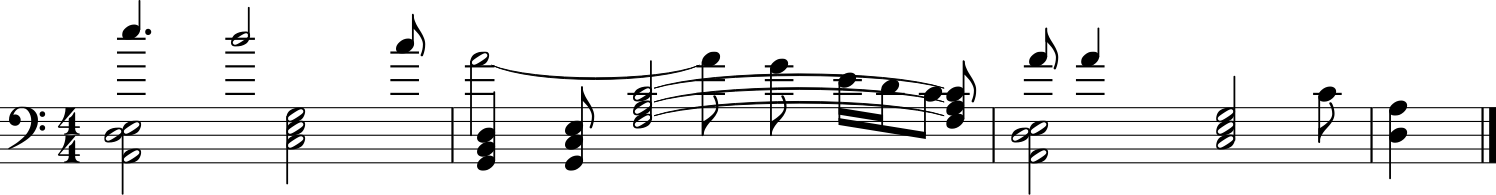

In [26]:
seed_stream = idxenc2stream(seed.cpu().numpy()[0])
seed_stream.show()

### Start Predictions:

In [28]:
out, seed = learn.predict(seed.cuda(), n_words=100)

Seed - used for prediction

Prediction

In [29]:
# Prediction
stream = idxenc2stream(out)
stream.show()

Non midi note detected. Only returning valid portion. Index, seed 3 (50, 2)


ValueError: negative dimensions are not allowed

In [ ]:
stream.show('midi')